In [1]:
# from scipy.stats import entropy
from scipy.stats.mstats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

from __init__ import *
from snmcseq_utils import create_logger
from snmcseq_utils import tsne_and_boxplot 
from CEMBA_update_mysql import connect_sql
from CEMBA_update_mysql import gene_id_to_table_name
from CEMBA_init_ensemble_v2 import pull_genebody_info 

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# import importlib
# import snmcseq_utils
# importlib.reload(snmcseq_utils)
# from snmcseq_utils import tsne_and_boxplot 


In [3]:
def get_cluster_mc_c_worker(df_cells, df_input, cluster_col):
    """reduce gene*cell or bin*cell matrix to a gene*cluster or bin*cluster matrix
    Arguments:
        - df_cells: a dataframe indexed by 'cell_name', and have '$cluster_col' as column
        - df_input: a dataframe with 'sample_mc', 'sample_c' ... as columns
        sample names are cell names
    """
    # cluster mc_c
    df_c = df_input.filter(regex='_c$')
    df_mc = df_input.filter(regex='_mc$')

    df_mc_c = pd.DataFrame() 
    for label, df_sub in df_cells.groupby(cluster_col):
        samples = df_sub.index.values
        df_mc_c['{}_mc'.format(label)] = df_mc[samples+'_mc'].sum(axis=1)
        df_mc_c['{}_c'.format(label)] = df_c[samples+'_c'].sum(axis=1)

    logging.info("Output shape: {}".format(df_mc_c.shape))
    return df_mc_c

In [4]:
def get_mcc(df, base_call_cutoff=100, sufficient_coverage_fraction=1):
    """Get mcc matrix from mc_c matrix (filtering out low coverage gene or bins)
    """
    logging.info('Getting mcc matrix from mc and c') 
    logging.info('base_call_cutoff={}, sufficient_coverage_fraction={}'.format(
                base_call_cutoff, sufficient_coverage_fraction))
    
    df_c = df.filter(regex="_c$")
    df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
    df_mc = df.filter(regex="_mc$")
    df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 
    # a gene is sufficiently covered in % of cells 
    condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

    logging.info("Matrix size before pruning... "+ str(df.shape))
    logging.info("Matrix size after pruning... "+ str(df.loc[condition].shape))
    
    # get mcc matrix with kept bins and nan values for low coverage sites
    df_c_nan = df_c.copy()
    df_c_nan[df_c < base_call_cutoff] = np.nan
    df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
    logging.info(df_mcc.shape)

    # imputation (missing value -> mean value of all cells)
    logging.info('Imputing data... (No effect if sufficient_coverage_fraction=1)')
    means = df_mcc.mean(axis=1)
    fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
    df_mcc.fillna(fill_value, inplace=True)
    
    # add suffix
    df_mcc.columns = df_mcc.columns.values + '_mcc'
    
    return df_mcc


In [5]:
def sum_of_square(array):
    dev = array - np.mean(array)
    return np.dot(dev, dev)

In [6]:
log = create_logger()

In [7]:
# set up
ens = 'Ens10'
context = 'CH'
cluster_col = 'cluster_mCHmCG_lv_npc50_k30'
cells_mc_c_file = None

ens_genelevel_path = os.path.join(PATH_ENSEMBLES, ens, 'gene_level')
engine = connect_sql(DATABASE)

In [8]:
# get gene annotation
sql = '''SELECT * FROM genes'''
df_genes = pd.read_sql(sql, engine, index_col='gene_id')

In [9]:
# get cells info
ens_path = os.path.join(PATH_ENSEMBLES, ens)
sql = """SELECT cell_name, dataset, global_m{}, {} FROM cells
        JOIN {} ON cells.cell_id = {}.cell_id""".format(context, cluster_col, ens, ens)
df_cells = pd.read_sql(sql, engine, index_col='cell_name') 


In [10]:
### get cells_mc_c
# If not provided, get default file path
if not cells_mc_c_file:
    cells_mc_c_file = os.path.join(PATH_ENSEMBLES, ens, 'gene_level', 'genebody_mCH_{}.tsv.bgz'.format(ens))

# If the file doesn't exist, pull from datasets (takes time)
if not os.path.isfile(cells_mc_c_file):
    ### pull genebody info
    # get cells and genebody paths
    logging.info("{} doesn't exist, pulling info from datasets... (This step takes time)".format(cells_mc_c_file))
    cells = []
    genebody_paths = []
    for dataset, df_sub in df_cells.groupby('dataset'):
        cells_tmp = sorted(df_sub.index.tolist())
        paths_tmp = [os.path.join(PATH_DATASETS, dataset, 'gene_level', 'genebody_{}.tsv.bgz'.format(cell)) 
                     for cell in cells_tmp]
        cells += cells_tmp
        genebody_paths += paths_tmp
        
    pull_genebody_info(ens, ens_genelevel_path, cells, genebody_paths, 
                    contexts=CONTEXTS, to_file=True)

# read cells_mc_c files
try:
    cells_mc_c = pd.read_table(cells_mc_c_file, compression='gzip', index_col='gene_id')
    logging.info("Got cells_mc_c matrix: {}".format(cells_mc_c.shape))
except:
    raise ValueError("Unable to read file {}".format(cells_mc_c_file))
    

03/19/2018 11:30:38 AM Got cells_mc_c matrix: (51772, 10704)


In [11]:
# get mcc (apply loose threshold)
cells_mcc = get_mcc(cells_mc_c, base_call_cutoff=20, sufficient_coverage_fraction=0.90)

# get nmcc
df_cells_copy = df_cells.copy()
df_cells_copy.index = df_cells.index.values + '_mcc'
cells_nmcc = cells_mcc.divide(df_cells_copy['global_mCH'], axis=1)

assert df_cells.shape[0] == cells_nmcc.shape[1]
logging.info("Done pre-processing. Resulting gene-by-cell normalized mcc matrix: {}".format(cells_nmcc.shape))

03/19/2018 11:30:38 AM Getting mcc matrix from mc and c
03/19/2018 11:30:38 AM base_call_cutoff=20, sufficient_coverage_fraction=0.9
03/19/2018 11:30:53 AM Matrix size before pruning... (51772, 10704)
03/19/2018 11:30:59 AM Matrix size after pruning... (19583, 10704)
03/19/2018 11:31:31 AM (19583, 5352)
03/19/2018 11:31:31 AM Imputing data... (No effect if sufficient_coverage_fraction=1)
03/19/2018 11:31:39 AM Done pre-processing. Resulting gene-by-cell normalized mcc matrix: (19583, 5352)


In [12]:
# eta-squared values (ANOVA)
df_sst = pd.DataFrame()
df_ssw = pd.DataFrame()
SSt = cells_nmcc.apply(sum_of_square, axis=1)
SSw = 0
for idx, df_sub in df_cells.groupby(cluster_col):
    cells = df_sub.index.values
    SSw += cells_nmcc[cells+'_mcc'].apply(sum_of_square, axis=1)

eta2 = 1 - SSw/SSt
logging.info("Done getting eta-squared values for genes ({} genes)".format(eta2.shape[0]))

03/19/2018 11:33:20 AM Done getting eta-squared values for genes (19583 genes)


In [13]:
# cluster_mc_c
cluster_mc_c = get_cluster_mc_c_worker(df_cells, cells_mc_c, cluster_col)
logging.info("Got cluster_mc_c matrix: {}".format(cluster_mc_c.shape))

03/19/2018 11:33:28 AM Output shape: (51772, 52)
03/19/2018 11:33:28 AM Got cluster_mc_c matrix: (51772, 52)


In [14]:
# cluster_mcc
cluster_mcc = get_mcc(cluster_mc_c)
logging.info("Got cluster_mcc matrix: {}".format(cluster_mcc.shape))

03/19/2018 11:33:28 AM Getting mcc matrix from mc and c
03/19/2018 11:33:28 AM base_call_cutoff=100, sufficient_coverage_fraction=1
03/19/2018 11:33:28 AM Matrix size before pruning... (51772, 52)
03/19/2018 11:33:28 AM Matrix size after pruning... (42908, 52)
03/19/2018 11:33:28 AM (42908, 26)
03/19/2018 11:33:28 AM Imputing data... (No effect if sufficient_coverage_fraction=1)
03/19/2018 11:33:28 AM Got cluster_mcc matrix: (42908, 26)


In [15]:
# normalize and rank percentile
data = cluster_mcc.apply(lambda x: zscore(x, ddof=1), axis=1)
data_pct = data.rank(pct=True, axis=0)

### Succeeded in detecting the following markers: 
#### Squared sum (and cubed sum)
- L2: Enpp2
- L4: Rorb
- Pv: Lrrc38, Pvalb

### statistical test 

### pairwise

In [16]:
### add measures to genes
# df_genes['entropy'] = (1-data_pct).apply(entropy, axis=1)
# df_genes['sum'] = (1-data_pct).sum(axis=1)

df_genes['squared_sum'] = (1-data_pct).applymap(lambda x: np.power(x, 2)).sum(axis=1)
df_genes['cubed_sum'] = (1-data_pct).applymap(lambda x: np.power(x, 3)).sum(axis=1)
df_genes = pd.merge(df_genes, eta2.to_frame('eta_squared'), 
                    left_index=True, right_index=True, how='left')


# df_genes.sort_values('squared_sum').head(50)

# a = data_pct[(data_pct['11_mcc'] < 0.02) & (data_pct['1_mcc'] > 0.80)].sort_values('11_mcc')
# a = data_pct[(data_pct['11_mcc'] < 0.01)]



In [29]:
markers_all = []
num_clusters = len(cluster_mcc.columns)
for i in range(num_clusters):
    
    marker_rows = 1 - data_pct[(data_pct['{}_mcc'.format(i+1)] < 0.02)]
    markers = df_genes.loc[marker_rows.index, :]
    markers = markers.fillna(0)  

    ### markers rank by overall zscore
    p = 0.7
    markers['zscore_squared_sum'] = zscore(markers['squared_sum'].values)
    markers['zscore_eta_squared'] = -zscore(markers['eta_squared'].values)
    markers['overall_score'] = (p*markers['zscore_squared_sum'] + (1-p)*markers['zscore_eta_squared'])
    markers = markers.sort_values('overall_score')

    markers_all += markers.head(10)['gene_name'].tolist()
    
markers_all = np.unique(markers_all)
len(markers_all)

186

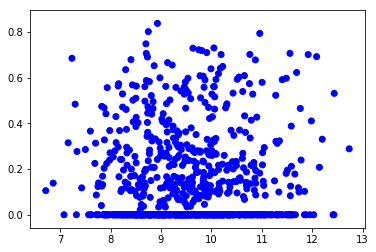

,gene_name,chr,start,end,strand,gene_type,squared_sum,cubed_sum,eta_squared,zscore_squared_sum,zscore_eta_squared,overall_score,color
gene_id,,,,,,,,,,,,,
ENSMUSG00000059187.12,Fam19a1,chr6,96113154,96657198,+,protein_coding,7.232574,5.716602,0.684304,-2.268617,-2.785127,-2.423570,blue
ENSMUSG00000022790.14,Igsf11,chr16,38892671,39027159,+,protein_coding,7.296214,5.737606,0.483650,-2.205819,-1.759223,-2.071840,blue
ENSMUSG00000089706.7,B230216N24Rik,chr1,98031116,98057680,-,processed_transcript,7.157528,5.901880,0.314682,-2.342669,-0.895321,-1.908465,blue
ENSMUSG00000087410.7,2310065F04Rik,chr11,67112461,67120080,-,lincRNA,6.712842,4.940895,0.105471,-2.781472,0.174335,-1.894730,blue
ENSMUSG00000039474.13,Wfs1,chr5,36966104,36989205,-,protein_coding,6.860089,4.256709,0.138407,-2.636173,0.005938,-1.843539,blue
ENSMUSG00000036469.16,March1,chr8,65617900,66471637,+,protein_coding,7.932944,5.787270,0.555964,-1.577512,-2.128950,-1.742944,blue
ENSMUSG00000022425.16,Enpp2,chr15,54838901,54952892,-,protein_coding,7.332686,5.213066,0.276846,-2.169829,-0.701875,-1.729443,blue
ENSMUSG00000098097.7,6530403H02Rik,chr3,120604109,120886733,-,lincRNA,7.823576,5.793520,0.474123,-1.685434,-1.710512,-1.692957,blue
ENSMUSG00000040183.13,Ankrd6,chr4,32804035,32950841,-,protein_coding,7.598452,5.289560,0.365836,-1.907580,-1.156862,-1.682364,blue


In [17]:
# organize this bit
# combine squared_sum and eta_squared
marker_rows = 1 - data_pct[(data_pct['2_mcc'] < 0.02)]
markers = df_genes.loc[marker_rows.index, :]
markers = markers.fillna(0)  
# markers = markers.dropna()  # remove genes with missing ANOVA values

### markers rank by measure1 measure2 seperately
# markers['rank_squared_sum'] = markers['squared_sum'].rank(pct=True, axis=0)
# markers['rank_eta_squared'] = markers['eta_squared'].rank(pct=True, axis=0, ascending=False)
# markers['overall_score'] = (0.7*markers['rank_squared_sum'] + 0.3*markers['rank_eta_squared'])
# markers = markers.sort_values('overall_score')

### markers rank by overall zscore
p = 0.7
markers['zscore_squared_sum'] = zscore(markers['squared_sum'].values)
markers['zscore_eta_squared'] = -zscore(markers['eta_squared'].values)
markers['overall_score'] = (p*markers['zscore_squared_sum'] + (1-p)*markers['zscore_eta_squared'])
markers = markers.sort_values('overall_score')

# plot markers on squared_sum and eta_squared
fig, ax = plt.subplots()
markers['color'] = ['black' if gene_name in 'Pvalb' else 'blue' for gene_name in markers['gene_name']]
ax.scatter(markers['squared_sum'].values, markers['eta_squared'].values, c=markers['color'].values)
plt.show()


# for i, (gene_id, gene_row) in enumerate(marker_rows.loc[markers.head(5).index, :].iterrows()):
#     area = np.power(gene_row.sort_values(), 2).sum()
#     plt.plot(gene_row.sort_values().values, label=area)

# c = 1 - data_pct.loc['ENSMUSG00000005716.16', :]
# area = np.power(c, 2).sum()
# plt.plot(c.sort_values().values, label='Pvalb {}'.format(area))
# plt.legend()
# plt.show()
markers.head(30)


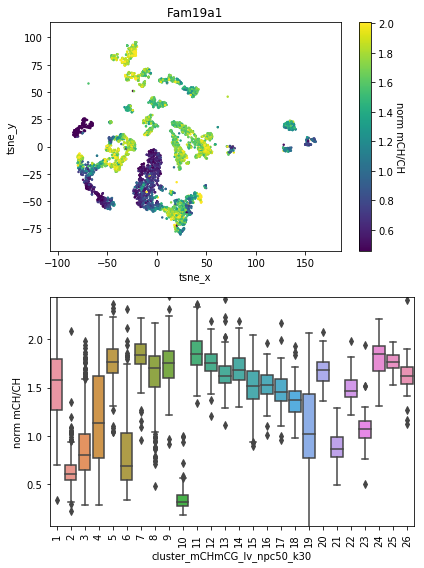

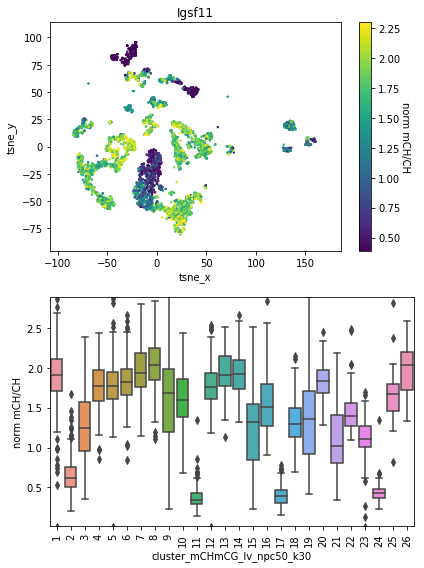

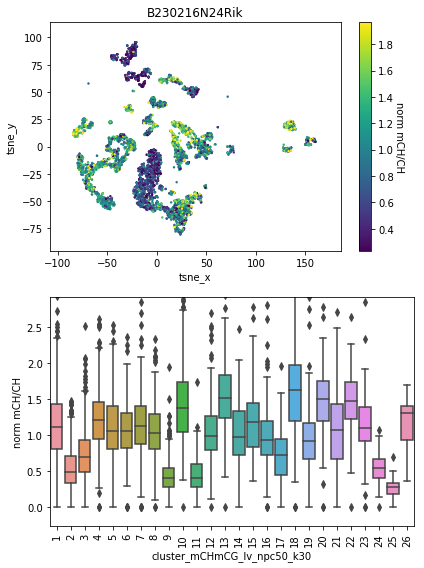

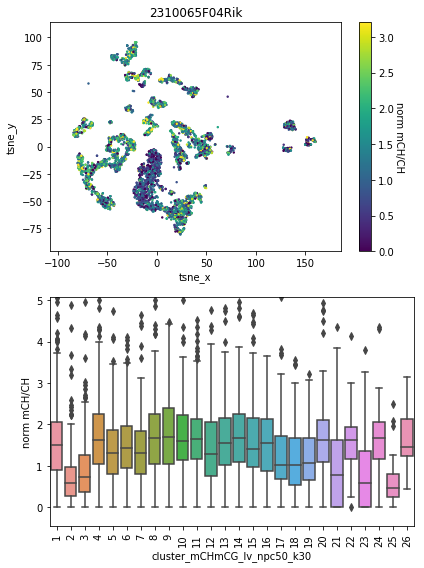

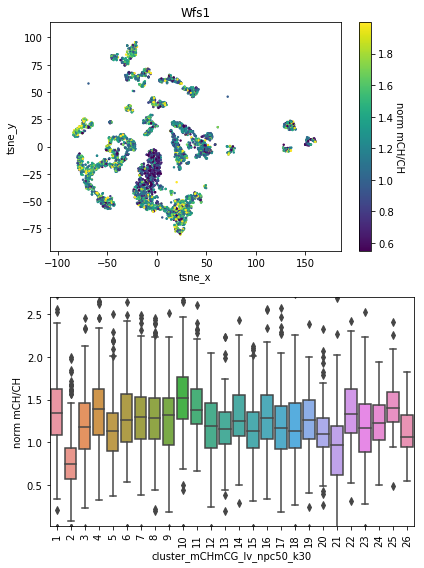

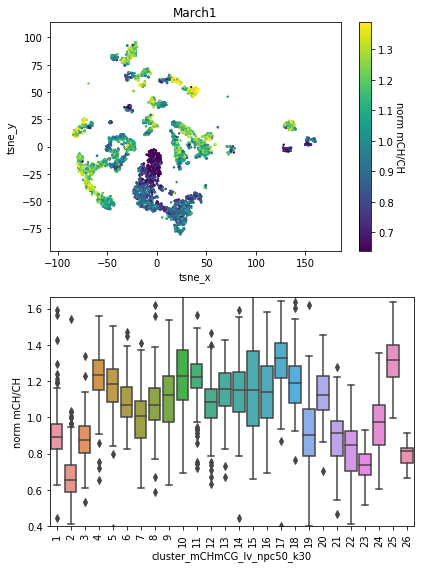

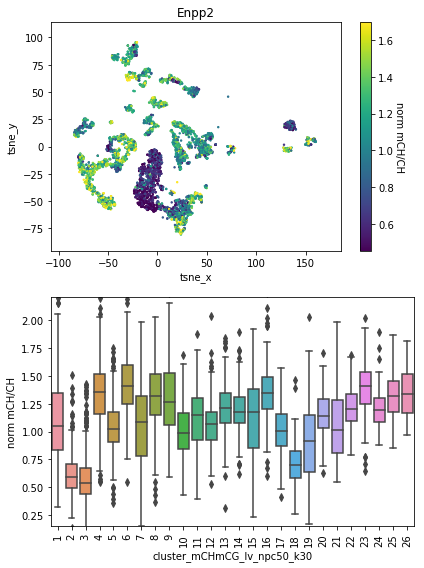

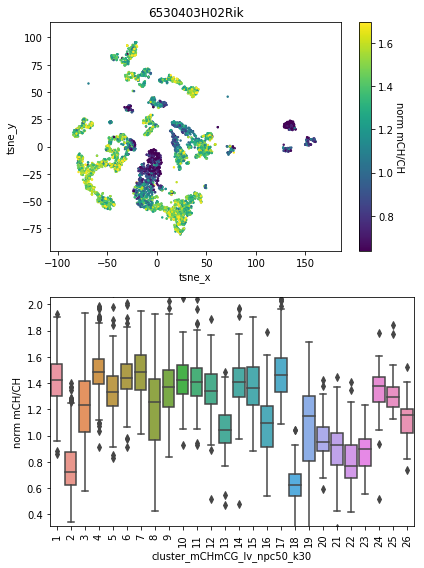

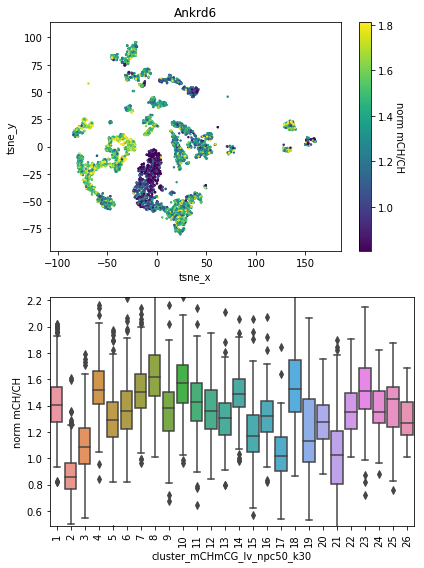

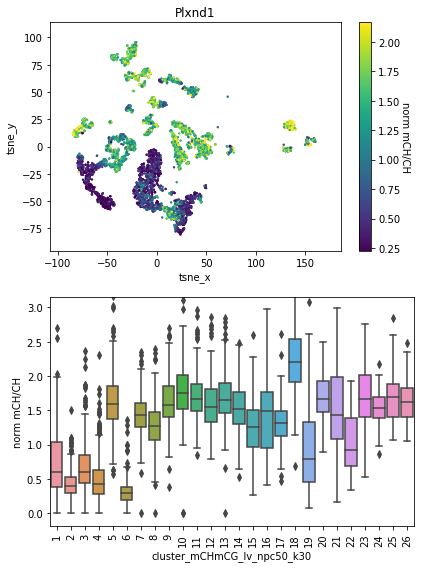

In [18]:
# visualization

engine = connect_sql(DATABASE)

# gene_names = ['Lrrc38', 'Pvalb', 'Erbb4', 'Gad1']
gene_names = markers.head(10)['gene_name'].tolist()
tsne_type = 'mCHmCG_ndim2_perp30'
cluster_type = 'mCHmCG_lv_npc50_k30'

gene_ids = [df_genes[df_genes['gene_name'] == gene_name].index.tolist()[0] for gene_name in gene_names] 
for gene_name, gene_id in zip(gene_names, gene_ids):
    gene_table = gene_id_to_table_name(gene_id) 
    sql = """SELECT tsne_x_{}, tsne_y_{}, cluster_{}, annotation_{}, mCH, CH, global_mCH FROM cells
    JOIN {} ON cells.cell_id = {}.cell_id
    JOIN {} ON cells.cell_id = {}.cell_id""".format(tsne_type, tsne_type, cluster_type, cluster_type, 
                                          ens, ens, 
                                         gene_table, gene_table)
    df_plot = pd.read_sql(sql, engine)
    df_plot['mCH/CH'] = df_plot['mCH']/df_plot['CH']
    df_plot['norm mCH/CH'] = df_plot['mCH/CH']/df_plot['global_mCH']
    tsne_and_boxplot(df_plot, tx='tsne_x_'+tsne_type, ty='tsne_y_'+tsne_type, tc='norm mCH/CH', 
                    bx='cluster_'+cluster_type, by='norm mCH/CH', title=gene_name)
    plt.show()
    
